# Week 7

This week, we consider two more basic classifiers to round out our toolbox of methods.

First is a parametric version of Linear Discriminant Analysis--i.e. a version that assumes a certain distribution of the data, in this case, multivariate normal. We further consider the more flexible Quadratic Discriminant Analysis. 

Second, we cover nearest-neighbor classifiers, which make almost no assumptions on the data or the decision boundaries. They are nevertheless often quite accurate. However, they are pretty unstable and not robust to small perturbations in the data

# Lecture 12: Linear and Quadratic Discriminant Analysis

Today, we will apply some of the theory from class to use linear discriminant analysis (and quadratic discriminant analysis) on some real classification problems. Let's import some libraries first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import time

from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

### (Fisher's) LDA Class

(Writing a class for Fisher's LDA will be a problem on Homework 3)

### DA Class

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

class DA(ClassifierMixin, BaseEstimator):
    def __init__(self, equalCovariances = True, alpha = 1, gamma = 1):
        # if True, LDA
        # if False, QDA
        self.equalCovariances = equalCovariances
        
        # if less than 1, regularized DA (requires QDA)
        self.alpha = alpha
        
        # if less than 1, shrinkage
        self.gamma = gamma
        
    def fit(self, X, Y):
        # find the unique labels
        uniqueY = np.unique(Y)
        
        # find the dimensions
        n = X.shape[0]
        self.d = X.shape[1]
        self.k = uniqueY.shape[0]

        # initialize the variables
        self.prior = np.zeros([self.k, 1])
        self.mu = np.zeros([self.k, 1, self.d])
        
        # compute the covariance matrix
        if self.equalCovariances or self.gamma < 1 or self.alpha < 1:
            mu = np.mean(X, axis = 0)
            Xbar = X - mu
            self.Sig = (1/n) * Xbar.T @ Xbar
            
            # shrinkage
            if self.gamma < 1:
                self.Sig = self.gamma * self.Sig + (1 - self.gamma) * np.diag(self.Sig)
                
            self.invCov = np.linalg.inv(self.Sig)
        
        if not self.equalCovariances:
            self.Sigma = np.zeros([self.k, self.d, self.d])            
        
        for i, y in enumerate(uniqueY):
            # extract a class of datapoints from X
            Xi = X[Y == y]
            
            # compute the size of each class
            ni = Xi.shape[0]
            
            # compute the priors
            self.prior[i] = ni / n
                        
            # compute the feature means within the class
            self.mu[i] = np.mean(Xi, axis = 0)
            
            # compute separate covariances for QDA
            if not self.equalCovariances:
                # compute the centered data
                XiBar = Xi - self.mu[i]
            
                # compute the class sample covariance
                self.Sigma[i] = (1/ni) * XiBar.T @ XiBar
                
                # regularization
                if self.alpha < 1:
                    self.Sigma[i] = self.alpha * self.Sigma[i] + (1 - self.alpha) * self.Sig
                
        
    def predict(self, X):
        n = X.shape[0]
        
        discriminants = np.zeros([n, self.k])
        
        for i, x in enumerate(X):
            x = np.atleast_2d(x).T
            
            for j in range(self.k):
                if not self.equalCovariances:
                    self.invCov = np.linalg.inv(self.Sigma[j])

                discriminants[i][j] = x.T @ self.invCov @ self.mu[j].T - (1/2) * self.mu[j] @ self.invCov @ self.mu[j].T + np.log(self.prior[j])

            
        predictions = np.argmax(discriminants, axis = 1)
        
        return predictions
    
    def score(self, X, y, sample_weight = None):
        return accuracy_score(y, self.predict(X), sample_weight = sample_weight)

### Example: Randomly Generated Points

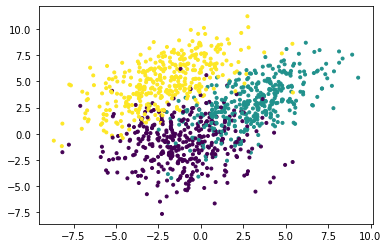

In [4]:
# number of points to generate
numberOfPoints = 500

# generate points from class 0
mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([3, 3])
covariance2 = np.array([[5, 3], [3, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# generate points from class 2
mean3 = np.array([-2, 5])
covariance3 = np.array([[5, 3], [3, 5]])
X3 = np.random.multivariate_normal(mean3, covariance3, numberOfPoints)

# stack the points
X = np.vstack((X1, X2, X3))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1], numberOfPoints * [2]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

#### Using Our DA method...


Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.86      0.83       120
           1       0.89      0.82      0.85       127
           2       0.91      0.91      0.91       128

    accuracy                           0.86       375
   macro avg       0.86      0.86      0.86       375
weighted avg       0.87      0.86      0.86       375


Confusion Matrix:



<AxesSubplot:>

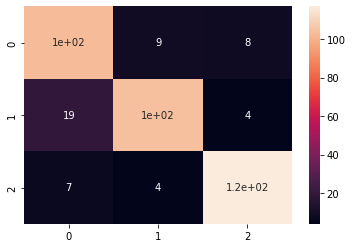

In [10]:
# fit the model to the training data
model = DA()
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Let's try with QDA.


Classification Report:

               precision    recall  f1-score   support

           0       0.83      0.84      0.83       120
           1       0.90      0.80      0.85       127
           2       0.87      0.95      0.91       128

    accuracy                           0.87       375
   macro avg       0.87      0.87      0.87       375
weighted avg       0.87      0.87      0.87       375


Confusion Matrix:



<AxesSubplot:>

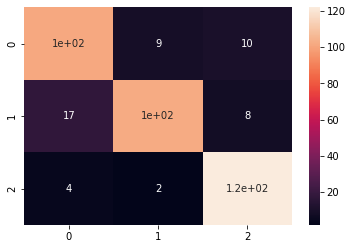

In [11]:
# fit the model to the training data
model = DA(equalCovariances = False)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Mean CV accuracy for parameters 0.1 0.1 is 0.8435555555555556
Mean CV accuracy for parameters 0.1 0.2 is 0.8497777777777777
Mean CV accuracy for parameters 0.1 0.3 is 0.8560000000000001
Mean CV accuracy for parameters 0.1 0.4 is 0.863111111111111
Mean CV accuracy for parameters 0.1 0.5 is 0.863111111111111
Mean CV accuracy for parameters 0.1 0.6 is 0.8675555555555554
Mean CV accuracy for parameters 0.1 0.7 is 0.8675555555555554
Mean CV accuracy for parameters 0.1 0.8 is 0.8684444444444445
Mean CV accuracy for parameters 0.1 0.9 is 0.8684444444444444
Mean CV accuracy for parameters 0.1 1.0 is 0.8622222222222222
Mean CV accuracy for parameters 0.2 0.1 is 0.847111111111111
Mean CV accuracy for parameters 0.2 0.2 is 0.8524444444444444
Mean CV accuracy for parameters 0.2 0.3 is 0.8577777777777778
Mean CV accuracy for parameters 0.2 0.4 is 0.8622222222222222
Mean CV accuracy for parameters 0.2 0.5 is 0.8648888888888889
Mean CV accuracy for parameters 0.2 0.6 is 0.8666666666666666
Mean CV acc

<AxesSubplot:>

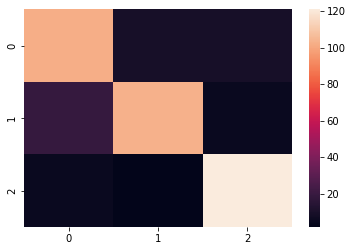

In [12]:
# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.19
for i in range(1, 11):
    for j in range(1, 11):
        alpha = i/10
        gamma = j/10

        # build the QDA classifier
        model = DA(False, alpha, gamma)

        # fit the QDA classifier to the training data
        model.fit(trainX, trainY)
        
        # compute the test predictions
        predictedY = model.predict(testX)

        # find the mean cross-validation accuracy
        mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

        # print quality metrics
        print('Mean CV accuracy for parameters', alpha, gamma, 'is', mean_cv_scores)

        # save the hyperparameter reg_param if better than found before
        if mean_cv_scores > bestAccuracy[0]:
            bestAccuracy = [mean_cv_scores, alpha, gamma]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with alpha =', bestAccuracy[1], 'and gamma =', bestAccuracy[2])
        
# build the QDA classifier
model = DA(False, bestAccuracy[1], bestAccuracy[2])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for the best hyperparameters:\n\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

#### `scikit-learn` Implementations

Now that we fully see how LDA and QDA work, we will rely on the optimized `scikit-learn` implementations of LDA and QDA.


Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.86      0.83       120
           1       0.91      0.81      0.86       127
           2       0.90      0.94      0.92       128

    accuracy                           0.87       375
   macro avg       0.87      0.87      0.87       375
weighted avg       0.87      0.87      0.87       375


Confusion Matrix:



<AxesSubplot:>

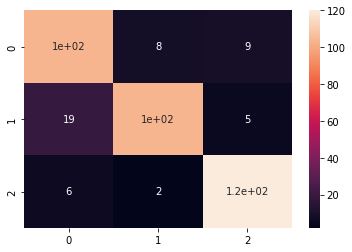

In [13]:
# fit the model to the training data
model = LinearDiscriminantAnalysis()
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

Mean CV accuracy for regularization parameter 0.0 is 0.8684444444444445
Mean CV accuracy for regularization parameter 0.01 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.02 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.03 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.04 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.05 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.06 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.07 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.08 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.09 is 0.8693333333333333
Mean CV accuracy for regularization parameter 0.1 is 0.8684444444444445
Mean CV accuracy for regularization parameter 0.11 is 0.8675555555555554
Mean CV accuracy for regularization parameter 0.12 is 0.8675555555555554
Mean CV accuracy for regularization parameter 0.13 is

<AxesSubplot:>

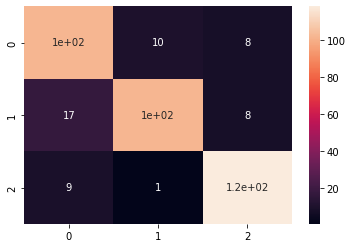

In [14]:
# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.20
for i in range(25):
    rp = i/100
    
    # build the QDA classifier
    model = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for regularization parameter', rp, 'is', mean_cv_scores)
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, rp]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'regularization parameter')
        
# build the QDA classifier
model = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy[1])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'reg_param:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Example from scikit-learn: LDA vs QDA

This example is lightly modified from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py).

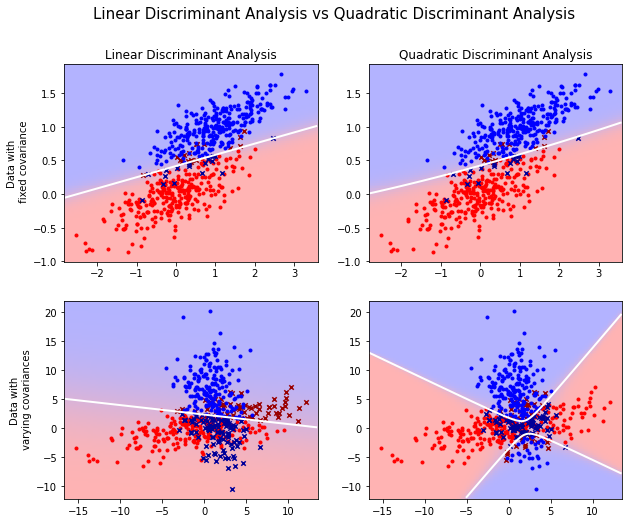

In [15]:
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

# Generate datasets
def dataset_fixed_cov():
    # Generate 2 Gaussians samples with the same covariance matrix
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C), np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

def dataset_cov():
    # Generate 2 Gaussians samples with different covariance matrices
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C), np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 100))
    
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes', norm=colors.Normalize(0., 1.), zorder=0, shading='auto')
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    return splot

plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis', y=0.98, fontsize=15)

for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis()
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)

### Example: Breast Cancer


Test Classification Report:

               precision    recall  f1-score   support

           0       1.00      0.75      0.86        57
           1       0.86      1.00      0.92        86

    accuracy                           0.90       143
   macro avg       0.93      0.88      0.89       143
weighted avg       0.92      0.90      0.90       143


Test Confusion Matrix:



<AxesSubplot:>

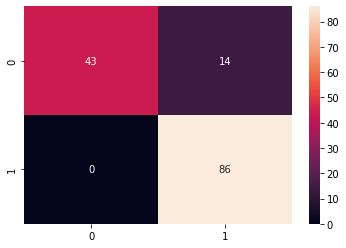

In [17]:
# import the breast cancer dataset
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = DA()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Example: Classifying MNIST Handwritten Digits with LDA and QDA

#### LDA


Training Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5923
           1       0.87      0.96      0.91      6742
           2       0.92      0.82      0.86      5958
           3       0.86      0.85      0.86      6131
           4       0.86      0.90      0.88      5842
           5       0.83      0.82      0.83      5421
           6       0.93      0.92      0.92      5918
           7       0.92      0.84      0.88      6265
           8       0.81      0.80      0.80      5851
           9       0.78      0.86      0.82      5949

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.89      0.97      0.93      1135
         

<AxesSubplot:>

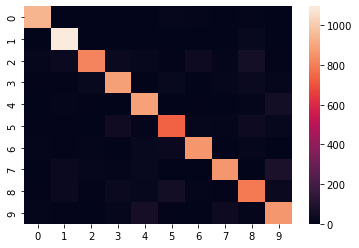

In [18]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = LinearDiscriminantAnalysis()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

#### LDA with Ledoit-Wolf shrinkage


Training Classification Report:

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5923
           1       0.87      0.96      0.91      6742
           2       0.92      0.82      0.87      5958
           3       0.86      0.84      0.85      6131
           4       0.87      0.90      0.88      5842
           5       0.84      0.83      0.83      5421
           6       0.93      0.92      0.93      5918
           7       0.93      0.85      0.89      6265
           8       0.81      0.80      0.81      5851
           9       0.79      0.88      0.83      5949

    accuracy                           0.88     60000
   macro avg       0.88      0.87      0.87     60000
weighted avg       0.88      0.88      0.88     60000


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.89      0.96      0.93      1135
         

<AxesSubplot:>

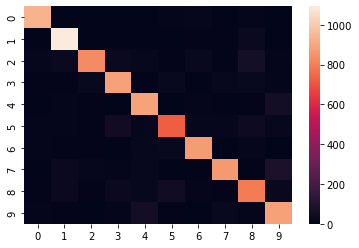

In [19]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

#### QDA

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# preprocess the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
trainX = trainX.astype('float')/255.0

testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])
testX = testX.astype('float')/255.0

# build the classifier
model = QuadraticDiscriminantAnalysis()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

TypeError: QuadraticDiscriminantAnalysis.__init__() got an unexpected keyword argument 'njobs'

#### QDA with Regularization

In [ ]:
# collinearity warnings keep popping up, so we suppress them
import warnings
warnings.filterwarnings('ignore')

# that is a BAD idea in general, I suppressed ALL warnings, so
# only do this if you are very brave!

# import MNIST data
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape the data
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2])
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2])

# normalize coordinates
trainX = trainX.astype('float')/255.0
testX = testX.astype('float')/255.0

# initialize accuracy and hyperparameter list
bestAccuracy = [0, 0]

# test regularization hyperparameters 0.00, 0.01, ..., 0.19
for i in range(20):
    rp = i/100
    
    # build the QDA classifier
    model = QuadraticDiscriminantAnalysis(reg_param = rp)

    # fit the QDA classifier to the training data
    model.fit(trainX, trainY)
    
    # find the mean cross-validation accuracy
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for regularization parameter', rp, 'is', mean_cv_scores)
    
    # save the hyperparameter reg_param if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, rp]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'regularization parameter')
        
# build the QDA classifier
model = QuadraticDiscriminantAnalysis(reg_param = bestAccuracy[1])

# fit the QDA classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[1], 'reg_param:\n\n', classification_report(testY, predictedY))

print('\nTest Confusion Matrix:\n')
sn.heatmap(confusion_matrix(testY, predictedY))

We now find 96% accuracy! This is easily the best result we have found for MNIST in the class so far.

# Lecture 13: $k$-Nearest Neighbors Classifier

The $k$-nearest neighbor classifier tries to classify numerical examples into categories. Suppose we have some labeled examples $x_1, ..., x_n\in\mathbb{R}^d$ with labels $y_1, ..., y_n$. If we have a new, unlabeled point $x$, we would like to predict its class label. The idea of the $k$-nearest neighbor algorithm is that we take the $k$ labeled examples nearest to $x$ and assign the most frequent class of these nearest "neighbors" to $x$.

## The Procedure to Classify an Example $x$ with $k$-Nearest Neighbors

1. Choose a positive integer for $k$.

1. Find the distances $\left\|x-x_j\right\|$ for each $j=1,...,n$ with any norm you choose.

1. Find the points with the $k$ shortest distances from $x$ (the $k$ nearest "neighbors").

1. Assign the most frequent class among the $k$ nearest neighbors to $x$

This means we need to make only two decisions two use the $k$-nearest neighbors: we need to choose a norm and we need to choose the number of neighbors $k$ to use. Customizable parameters for a machine learning method like this $k$-nearest neighbor classifier are called **hyperparameters**. It is not generally obvious how to choose these hyperparameters and it tends to be pretty experimental. Tuning hyperparameters is a large part of machine learning.

## $k$-Nearest Neighbor Code

Let's write some code. I will use the style used by the popular machine learning library <a href="https://scikit-learn.org/stable/">scikit-learn</a>, where a classifier is written as a class in the programming sense (not to be confused with the "classes" of our classification problem) with hyperparameters as inputs. The classifier's class will have some functions that fit the model to the data and predict the class of input datapoints.

The `fit` function for the $k$-nearest neighbors will do very little but record some data. The 'predict' function will carry out steps 1-4 above.

First, we import some libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from scipy.stats import mode
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist

In [3]:
# Create a class for the k-nearest neighbor classifier
class kNearestNeighborClassifier:
    # constructor to save the hyperparameter k
    def __init__(self, k = 5):
        # initialize the number of neighbors to use
        self.neighbors = k
    
    # fit the model to the training data (for kNN, there's no actual fitting involved)
    def fit(self, X, y):
            
        # record the data and labels
        self.data = X
        self.labels = y
    
    # use the classifier to predict the classifications of the testing data
    def predict(self, X):
        # initialize the predicted classes
        yPredicted = np.empty([X.shape[0],1])
        
        # loop over the datapoints in X
        for row in range(X.shape[0]):
            datapoint = X[row,]
            
            # find the distances from the datapoint to each training point using the L2 norm
            distances = np.sqrt(np.sum(((self.data - datapoint)**2), axis = 1))
            
            # find the indices of the smallest k distances
            indices = np.argsort(distances)[:self.neighbors]
            
            # find the the class labels of the nearest neighbors
            nearestClasses = self.labels[indices]
            
            # determine the predicted class by finding the mode
            yPredicted[row] = int(mode(nearestClasses)[0][0])
            
        return yPredicted

## Example: Randomly Generated Points

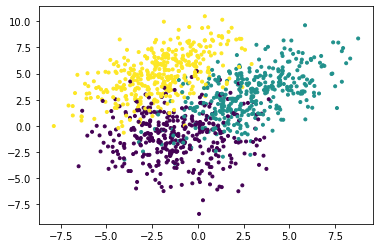

In [4]:
# number of points to generate
numberOfPoints = 500

# generate points from class 0
mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([3, 3])
covariance2 = np.array([[5, 3], [3, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# generate points from class 2
mean3 = np.array([-2, 5])
covariance3 = np.array([[5, 3], [3, 5]])
X3 = np.random.multivariate_normal(mean3, covariance3, numberOfPoints)

# stack the points
X = np.vstack((X1, X2, X3))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1], numberOfPoints * [2]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.80      0.79       120
           1       0.83      0.80      0.81       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

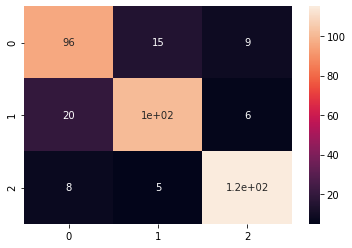

In [5]:
# fit the model to the training data
model = kNearestNeighborClassifier(k = 3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

The code above computes the neighbors in a pretty brute-force way, which is pretty slow, so it is generally best to use an existing implementation like `KNeighborsClassifier` in `scikit-learn`.


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.80      0.79       120
           1       0.83      0.80      0.81       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

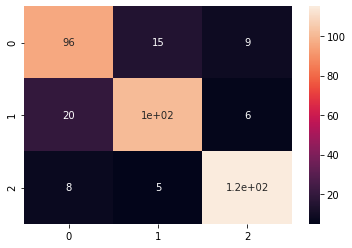

In [6]:
# fit the model to the training data
model = KNeighborsClassifier(3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)


Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.81      0.79       120
           1       0.82      0.78      0.80       127
           2       0.88      0.90      0.89       128

    accuracy                           0.83       375
   macro avg       0.83      0.83      0.83       375
weighted avg       0.83      0.83      0.83       375


Confusion Matrix:



<AxesSubplot:>

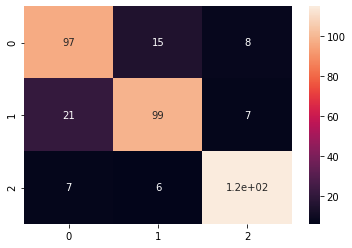

In [7]:
# fit the model to the training data
model = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

## Classifying MNIST Handwritten Digits with $k$-NN

Dev classification accuracy 1 neighbors is 0.871
Dev classification accuracy 2 neighbors is 0.85
Dev classification accuracy 3 neighbors is 0.853
Dev classification accuracy 4 neighbors is 0.854
Dev classification accuracy 5 neighbors is 0.838
Dev classification accuracy 6 neighbors is 0.839
Dev classification accuracy 7 neighbors is 0.83
Dev classification accuracy 8 neighbors is 0.836
Dev classification accuracy 9 neighbors is 0.821
Dev classification accuracy 10 neighbors is 0.819

The best dev accuracy 0.871 occured with 1 neghbors

Test Classification Report for 0.871 neighbors:

               precision    recall  f1-score   support

           0       0.91      0.97      0.94        97
           1       0.88      1.00      0.94       106
           2       0.94      0.89      0.91       108
           3       0.92      0.83      0.87       120
           4       0.85      0.83      0.84        87
           5       0.72      0.73      0.73        75
           6       0.92     

<AxesSubplot:>

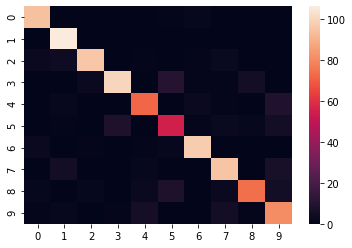

In [8]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.5)

trainX = trainX[:1000]
devX = devX[:1000]
testX = testX[:1000]
trainY = trainY[:1000]
devY = devY[:1000]
testY = testY[:1000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)

    # predict the labels of the test set
    predictedY = model.predict(devX)
    
    # compute the accuracy
    acc = accuracy_score(devY, predictedY)
    
    # print quality metrics
    print('Dev classification accuracy', k, 'neighbors is', acc)
    
    # save the hyperparameter k if better than found before
    if acc > bestAccuracy[0]:
        bestAccuracy = [acc, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.9393
Mean CV accuracy for 2 neighbors is 0.9307000000000001
Mean CV accuracy for 3 neighbors is 0.9395000000000001
Mean CV accuracy for 4 neighbors is 0.9405000000000001
Mean CV accuracy for 5 neighbors is 0.9377000000000001
Mean CV accuracy for 6 neighbors is 0.9362999999999999
Mean CV accuracy for 7 neighbors is 0.9359999999999999
Mean CV accuracy for 8 neighbors is 0.9343999999999999
Mean CV accuracy for 9 neighbors is 0.9345000000000001
Mean CV accuracy for 10 neighbors is 0.9341000000000002

The best dev accuracy 0.9405000000000001 occured with 4 neghbors

Test Classification Report for 0.9405000000000001 neighbors:

               precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.91      0.99      0.95      1135
           2       0.97      0.92      0.95      1032
           3       0.92      0.95      0.94      1010
           4       0.96      0.95      0.95       982
      

<AxesSubplot:>

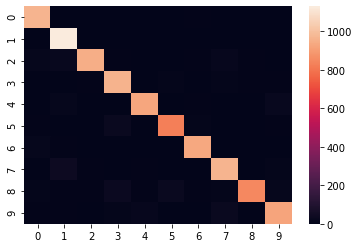

In [9]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

trainX = trainX[:10000]
testX = testX[:10000]
trainY = trainY[:10000]
testY = testY[:10000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

This is quite good accuracy at 94%!